In [1]:
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
batch_num = 0

/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
rnn = RNN()
rnn.set_weights('./rnn/weights.h5')

vae = VAE()
vae.set_weights('./vae/weights.h5')

In [3]:
obs_data = np.load('./data/obs_data_car_racing_' + str(batch_num) + '.npy') 
action_data = np.load('./data/action_data_car_racing_' + str(batch_num) + '.npy')
reward_data = np.load('./data/reward_data_car_racing_' + str(batch_num) + '.npy') 
done_data = np.load('./data/done_data_car_racing_' + str(batch_num) + '.npy')
rnn_input = np.load('./data/rnn_input_' + str(batch_num) + '.npy') 
rnn_output = np.load('./data/rnn_output_' + str(batch_num) + '.npy')

In [4]:
rnn_input[0].shape

(299, 35)

In [5]:
rnn_output[0].shape

(299, 34)

In [6]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32
z_dim = 32

def get_mixture_coef(y_pred):

    d = GAUSSIAN_MIXTURES * Z_DIM

    rollout_length = y_pred.shape[1]

    pi = y_pred[:,:,:d]
    mu = y_pred[:,:,d:(2*d)]
    log_sigma = y_pred[:,:,(2*d):(3*d)]
    reward = y_pred[:,:,(3*d):(3*d+1)]
    done = y_pred[:,:,(3*d+1):]

    pi = np.reshape(pi, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
    mu = np.reshape(mu, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
    log_sigma = np.reshape(log_sigma, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])

    pi = np.exp(pi) / np.sum(np.exp(pi), axis=2, keepdims=True)
    sigma = np.exp(log_sigma)

    return pi, mu, sigma, reward, done

In [7]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  random_value = np.random.randint(N)
  #print('error with sampling ensemble, returning random', random_value)
  return random_value

In [8]:
def sample_z(mu, sigma):
    z = mu + sigma * np_random.randn(*sigma.shape)
    return z

In [9]:
np_random, seed = seeding.np_random()

In [10]:
def sample_next_mdn_output(obs):
    
    y_pred = rnn.model.predict(np.array([[obs]]))
    _pi, _mu, _sigma, _reward, _done = get_mixture_coef(y_pred)

    pi = _pi[0,0,:,:]
    mu = _mu[0,0,:,:]
    sigma = _sigma[0,0,:,:]
    reward = _reward[0,0,:]
    done = _done[0,0,:]

    chosen_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_sigma = np.zeros(z_dim)

    for j in range(z_dim):
      idx = get_pi_idx(np_random.rand(), pi[:,j])
      chosen_pi[j] = idx
      chosen_mu[j] = mu[idx, j]
      chosen_sigma[j] = sigma[idx, j]

    next_z = sample_z(chosen_mu, chosen_sigma)

    reward = np.exp(reward) / (1 + np.exp(reward))
    done = np.exp(done) / (1 + np.exp(done))

    if reward > 0.5:
        next_reward = 3.2
    else:
        next_reward = -0.1

    if done > 0.5:
        next_done = True
    else:
        next_done = False
        
    return next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi

In [11]:
idx = 75
obs = rnn_input[0][idx]
actual = rnn_output[0][idx] 
print(obs)
print(actual)

[ 0.09903694 -0.4241842  -0.0196132  -1.58889688 -2.07245027  0.06449286
  1.26596314  0.12766996 -0.85658666 -1.08248857  0.13957446 -2.17899252
  0.02293727  0.12922618  1.31168869  0.34737417 -0.51875591  0.05377751
 -2.57555877  0.37708434 -0.26289903  0.11891239  0.12990692  0.20979169
 -1.97108139 -0.78712971  0.26978854 -0.17628121  0.28688138  0.93972955
 -0.70267182  0.00829816  0.          0.32002393  0.        ]
[-0.35088536  0.2006762   0.96157022 -1.0847546   1.77705224  0.4077006
  0.89167035 -0.97593187 -1.62714711 -1.05991577  0.17351801 -2.1676139
  1.28694344  0.21733318  1.48546286 -0.54187198  0.01175269 -0.66152963
  0.58711396  0.67408825 -0.15064799  0.16415768  0.21054918  0.14690109
 -1.89797578  0.3472241  -0.248941   -1.2810302  -0.01938026  0.95774316
  0.50793918 -0.38324722  0.          0.        ]


In [12]:
vae.encoder_mu_log_var.predict(np.array([obs_data[4][idx]]))

[array([[-0.04655426, -0.06652027,  0.06326062, -0.42641288,  0.00919756,
         -0.01866326, -0.06720687, -0.11880322, -0.36281854,  2.174596  ,
         -0.07334159,  1.1118139 ,  0.02508092, -0.03761369,  1.1402255 ,
         -0.03602701, -0.06486706,  0.01028838, -0.0713533 ,  0.5850992 ,
          0.10928901, -0.63460094, -0.19474973,  2.508924  ,  0.09320733,
         -0.06999912, -0.10844857, -0.0505893 , -0.03813688, -0.73185563,
         -0.1700342 ,  0.00670168]], dtype=float32),
 array([[-0.20716761, -0.2241945 , -2.9716222 , -3.7824056 , -0.1779578 ,
         -0.20479113, -0.06859446, -0.24500974, -2.9006107 , -3.7709582 ,
         -3.7229276 , -3.2448142 , -0.28490752, -0.08096436, -3.624618  ,
         -0.14321962, -0.1685074 , -0.1148582 , -0.11384161, -3.3880105 ,
         -1.1003023 , -5.0126424 , -3.6125197 , -4.3030343 , -0.06409626,
         -0.344004  , -0.05606374, -0.09560605, -0.17806885, -5.0438585 ,
         -0.17223486, -0.12612966]], dtype=float32)]

<function matplotlib.pyplot.show>

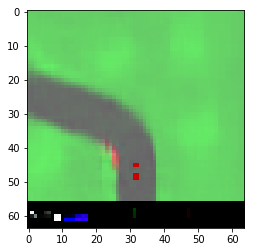

In [15]:
z_decoded = vae.decoder.predict(np.array([obs[:32]]))[0]
plt.imshow(z_decoded)
plt.show

<function matplotlib.pyplot.show>

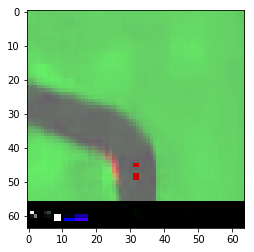

In [16]:
actual_z_decoded = vae.decoder.predict(np.array([actual[:32]]))[0]
plt.imshow(actual_z_decoded)
plt.show

<function matplotlib.pyplot.show>

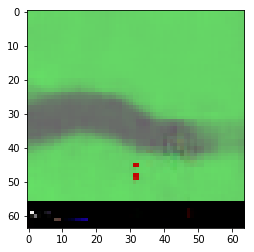

In [30]:
next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi = sample_next_mdn_output(obs)
# print(chosen_pi)
# print(chosen_mu)
# print(chosen_sigma)
# print(next_z)

next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
plt.imshow(next_z_decoded)
plt.show

<function matplotlib.pyplot.show>

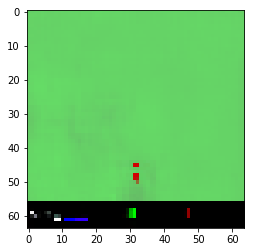

In [121]:
next_z_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]
plt.imshow(next_z_decoded)
plt.show

In [66]:
y_pred = rnn.model.predict(np.array([[obs]]))

In [67]:
d = GAUSSIAN_MIXTURES * Z_DIM

rollout_length = y_pred.shape[1]

pi = y_pred[:,:,:d]
mu = y_pred[:,:,d:(2*d)]
log_sigma = y_pred[:,:,(2*d):(3*d)]
reward = y_pred[:,:,(3*d):(3*d+1)]
done = y_pred[:,:,(3*d+1):]

In [104]:
next_reward

3.2

In [69]:
pi = np.reshape(pi, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
mu = np.reshape(mu, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
log_sigma = np.reshape(log_sigma, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])

pi = np.exp(pi) / np.sum(np.exp(pi), axis=2, keepdims=True)
sigma = np.exp(log_sigma)

In [72]:
pi

array([[0.17332809, 0.15662955, 0.5179722 , 0.12759934, 0.30732554,
        0.17080006, 0.2102053 , 0.08229304, 0.18730298, 0.03496384,
        0.02969552, 0.57183135, 0.19361672, 0.18950164, 0.1198101 ,
        0.22958122, 0.22072983, 0.1457007 , 0.15459353, 0.12570432,
        0.08773788, 0.19110036, 0.16422896, 0.21568958, 0.19818835,
        0.21710834, 0.16740966, 0.15359114, 0.21590596, 0.4934277 ,
        0.24480711, 0.17650785],
       [0.22193207, 0.29621163, 0.09746887, 0.05463479, 0.16884992,
        0.1594192 , 0.25685322, 0.19471781, 0.10183731, 0.81247836,
        0.02993079, 0.18325275, 0.21753056, 0.22377491, 0.09063044,
        0.19951849, 0.19882415, 0.23059364, 0.2407695 , 0.5040187 ,
        0.35482338, 0.12694892, 0.1462783 , 0.30202433, 0.22349992,
        0.1887898 , 0.20789021, 0.20232292, 0.19281134, 0.05054078,
        0.18103147, 0.21313494],
       [0.20519508, 0.13278729, 0.12306818, 0.39879134, 0.15186526,
        0.25440022, 0.17028476, 0.2742324 , 0.2271

In [73]:
_pi, _mu, _sigma, _reward, _done = get_mixture_coef(y_pred)

pi = _pi[0,0,:,:]
mu = _mu[0,0,:,:]
sigma = _sigma[0,0,:,:]
reward = _reward[0,0,:]
done = _done[0,0,:]

In [74]:
y_pred

array([[[-1.68347016e-01, -1.90562665e-01,  1.21322262e+00,
         -3.55270863e-01,  4.74886239e-01, -1.36428162e-01,
          9.54303741e-02, -7.49945045e-01,  8.61841142e-02,
         -9.85395193e-01, -1.47785938e+00,  1.67253900e+00,
         -6.77092373e-03, -3.82327065e-02, -1.72302946e-01,
          1.54613048e-01,  9.18919295e-02, -3.23471159e-01,
         -2.25866660e-01, -1.83158055e-01, -4.63916808e-01,
          2.46700436e-01, -2.93200426e-02,  2.49242276e-01,
          1.30517501e-03,  7.52091333e-02, -9.97870788e-02,
         -2.73043364e-01,  1.00666545e-01,  1.32277870e+00,
          2.18165472e-01, -1.91230029e-01,  7.88380802e-02,
          4.46628064e-01, -4.57165897e-01, -1.20349538e+00,
         -1.24011151e-01, -2.05384612e-01,  2.95850515e-01,
          1.11319661e-01, -5.23166895e-01,  2.16037965e+00,
         -1.46996760e+00,  5.34561217e-01,  1.09687872e-01,
          1.28010362e-01, -4.51420695e-01,  1.42629780e-02,
         -1.26267616e-02,  1.35631353e-0